In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
Products = pd.DataFrame({
    "Class":       [" A ", "B", "a", "C", None, "B", "A", "B ", "c", "A"],
    "Region":      ["east", " West", "North ", "east", "south", None, "west", " EAST", "south ", "north"],
    "Month":       ["Jan", "JAN", "Feb ", "2", "Mar", "Mar", "Apr", "APR", None, "Apr"],
    "Units_sold":  [120, 95, 80, 110, 75, np.nan, 90, 100, 85, np.nan],
    "Unit_price":  [15, 20, "15", 10, 12, 18, None, "19", 11, np.nan],
    # Intentionally NOT setting Revenue; we’ll compute after cleaning
})

print(Products)
print(Products.info())
print(Products.describe().round(2))

  Class  Region Month  Units_sold Unit_price
0    A     east   Jan       120.0         15
1     B    West   JAN        95.0         20
2     a  North   Feb         80.0         15
3     C    east     2       110.0         10
4  None   south   Mar        75.0         12
5     B    None   Mar         NaN         18
6     A    west   Apr        90.0       None
7    B     EAST   APR       100.0         19
8     c  south   None        85.0         11
9     A   north   Apr         NaN        NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Class       9 non-null      object 
 1   Region      9 non-null      object 
 2   Month       9 non-null      object 
 3   Units_sold  8 non-null      float64
 4   Unit_price  8 non-null      object 
dtypes: float64(1), object(4)
memory usage: 532.0+ bytes
None
       Units_sold
count        8.00
mean        94.38
s

In [4]:
def normalize_month(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    m = {
        "jan":"Jan","1":"Jan","01":"Jan",
        "feb":"Feb","2":"Feb","02":"Feb",
        "mar":"Mar","3":"Mar","03":"Mar",
        "apr":"Apr","4":"Apr","04":"Apr",
        "may":"May","5":"May","05":"May",
        "jun":"Jun","6":"Jun","06":"Jun",
        "jul":"Jul","7":"Jul","07":"Jul",
        "aug":"Aug","8":"Aug","08":"Aug",
        "sep":"Sep","9":"Sep","09":"Sep",
        "oct":"Oct","10":"Oct",
        "nov":"Nov","11":"Nov",
        "dec":"Dec","12":"Dec"
    } # All kinds of possible different entries for different months will be like: Jan,Feb,...
    return m.get(s, np.nan)

Products["Class"] = Products["Class"].astype("string").str.strip().str.upper()
Products["Region"] = Products["Region"].astype("string").str.strip().str.title()
Products["Month"] = Products["Month"].apply(normalize_month) 
# we added a function to our data cleaning process with .apply()

print(Products[["Class", "Region", "Month"]])

  Class Region Month
0     A   East   Jan
1     B   West   Jan
2     A  North   Feb
3     C   East   Feb
4  <NA>  South   Mar
5     B   <NA>   Mar
6     A   West   Apr
7     B   East   Apr
8     C  South   NaN
9     A  North   Apr


In [5]:
Products["Units_sold"] = pd.to_numeric(Products["Units_sold"], errors='coerce')
Products['Unit_price'] = pd.to_numeric(Products["Unit_price"], errors='coerce')
Products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Class       9 non-null      string 
 1   Region      9 non-null      string 
 2   Month       9 non-null      object 
 3   Units_sold  8 non-null      float64
 4   Unit_price  8 non-null      float64
dtypes: float64(2), object(1), string(2)
memory usage: 532.0+ bytes


In [6]:
# Fill unit price
Price_by_class = Products.groupby("Class")["Unit_price"].transform("median")
Products["Unit_price"] = Products["Unit_price"].fillna(Price_by_class)
Products["Unit_price"] = Products["Unit_price"].fillna(Products["Units_sold"].median())

# Fill units sold
units_by_region = Products.groupby("Region")["Units_sold"].transform("median")
Products["Units_sold"] = Products["Units_sold"].fillna(units_by_region)
Products["Units_sold"] = Products["Units_sold"].fillna(Products["Units_sold"].median())

# Drop rows that still lack key categorical fields
Products = Products.dropna(subset=["Class", "Region", "Month"]).reset_index(drop=True)

print(Products)
print("\nMissing after fill:")
print(Products.isna().sum())

  Class Region Month  Units_sold  Unit_price
0     A   East   Jan       120.0        15.0
1     B   West   Jan        95.0        20.0
2     A  North   Feb        80.0        15.0
3     C   East   Feb       110.0        10.0
4     A   West   Apr        90.0        15.0
5     B   East   Apr       100.0        19.0
6     A  North   Apr        80.0        15.0

Missing after fill:
Class         0
Region        0
Month         0
Units_sold    0
Unit_price    0
dtype: int64


In [7]:
Products["Revenue"] = (Products["Units_sold"] * Products["Unit_price"]).round(2)
print(Products.head())
# I made a new column, and named it Revenue and multiplied Units_sold with Unit_price to 
#calculate the Revenue value for each column.

  Class Region Month  Units_sold  Unit_price  Revenue
0     A   East   Jan       120.0        15.0   1800.0
1     B   West   Jan        95.0        20.0   1900.0
2     A  North   Feb        80.0        15.0   1200.0
3     C   East   Feb       110.0        10.0   1100.0
4     A   West   Apr        90.0        15.0   1350.0


In [8]:
q1 = Products["Unit_price"].quantile(0.33) # lower quantile
q2 = Products["Unit_price"].quantile(0.66) # higher quantile
#everythin between is affordable

def price_band(u, low, high):
    if u < low:
        return "Cheap"
    elif u > high:
        return "Expensive"
    else:
        return "Affordable"
    # I made 3 different price bands.  
    
Products["Price_band"] = Products["Unit_price"].apply(lambda u: price_band(u, q1, q2))
print(Products[["Unit_price", "Price_band"]])
print(Products["Price_band"].value_counts())

   Unit_price  Price_band
0        15.0  Affordable
1        20.0   Expensive
2        15.0  Affordable
3        10.0       Cheap
4        15.0  Affordable
5        19.0   Expensive
6        15.0  Affordable
Price_band
Affordable    4
Expensive     2
Cheap         1
Name: count, dtype: int64


In [9]:
class SalesAnalyzer:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def revenue_by_region(self):
        return self.df.groupby("Region")["Revenue"].sum().sort_values(ascending=False)
    
    def monthly_revenue_by_class(self):
        return (self.df.groupby(["Month", "Class"])["Revenue"].sum().unstack("Class").fillna(0).sort_index())
    
    def price_band_counts(self):
        return self.df["Price_band"].value_counts()
    
an = SalesAnalyzer(Products)
print(an.revenue_by_region())
print(an.monthly_revenue_by_class())
print(an.price_band_counts())

Region
East     4800.0
West     3250.0
North    2400.0
Name: Revenue, dtype: float64
Class       A       B       C
Month                        
Apr    2550.0  1900.0     0.0
Feb    1200.0     0.0  1100.0
Jan    1800.0  1900.0     0.0
Price_band
Affordable    4
Expensive     2
Cheap         1
Name: count, dtype: int64


In [10]:
class SalesVisualizer:
    def __init__(self, df):
        self.df = df

    def plot_revenue_by_region(self):
        plt.figure(figsize=(6,4))
        sns.barplot(data=self.df, x="Region", y="Revenue", estimator="sum", ci=None)
        plt.title("Total Revenue by Region")
        plt.xlabel("Region")
        plt.ylabel("Total Revenue")
        plt.tight_layout()
        plt.show()

    def plot_monthly_revenue_by_class(self):
        plt.figure(figsize=(6,4))
        month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
        order = [m for m in month_order if m in self.df["Month"].unique()]
        sns.barplot(
            data=self.df, x="Month", y="Revenue", hue="Class",
            estimator="sum", ci=None, order=order
        )
        plt.title("Monthly Revenue by Class")
        plt.xlabel("Month")
        plt.ylabel("Total Revenue")
        plt.legend(title="Class")
        plt.tight_layout()
        plt.show()

    def plot_price_band_counts(self):
        plt.figure(figsize=(6,4))
        sns.countplot(data=self.df, x="Price_band", palette="Set2")
        plt.title("Count of Products by Price Band")
        plt.xlabel("Price Band")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

C:\Users\Pooria\AppData\Local\Temp\ipykernel_5112\736376597.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


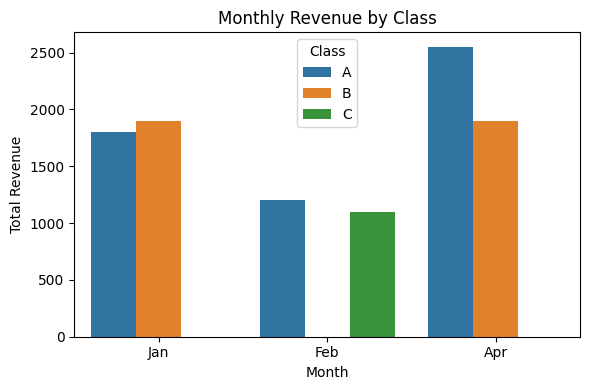

C:\Users\Pooria\AppData\Local\Temp\ipykernel_5112\736376597.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=self.df, x="Region", y="Revenue", estimator="sum", ci=None)


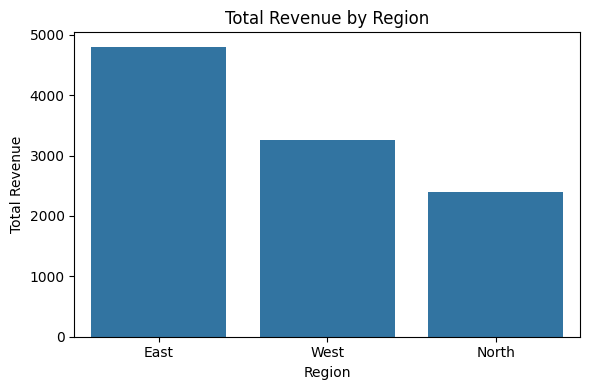

C:\Users\Pooria\AppData\Local\Temp\ipykernel_5112\736376597.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=self.df, x="Price_band", palette="Set2")


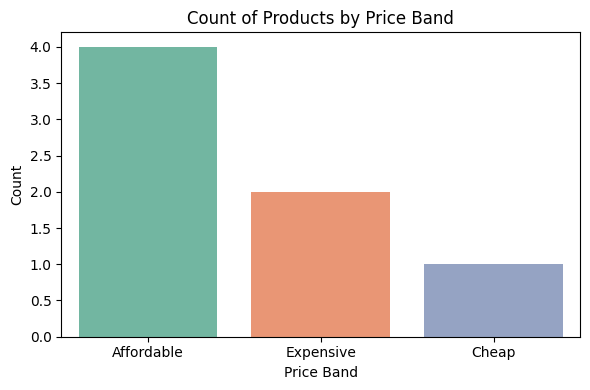

In [11]:
df = Products.copy()
visual = SalesVisualizer(df)
visual.plot_monthly_revenue_by_class()
visual.plot_revenue_by_region()
visual.plot_price_band_counts()